# Transportation Usage Forecasting

This project involves predicting the number of passengers on a new transit system based on historical data.

Loading packages

In [1]:
library(ggplot2)
library(lattice)
library(caret)
library(dplyr)
library(stringr)
library(lubridate)
library(readr)
library(tidyr)
options(repos='https://cran.cnr.berkeley.edu/')
install.packages('EnvStats')
install.packages('aTSA')
library(forecast)
library(EnvStats)
library(aTSA)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



package 'EnvStats' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nolan\AppData\Local\Temp\RtmpQZ11bz\downloaded_packages
package 'aTSA' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Nolan\AppData\Local\Temp\RtmpQZ11bz\downloaded_packages


Warning message:
"package 'EnvStats' was built under R version 3.5.3"
Attaching package: 'EnvStats'

The following objects are masked from 'package:stats':

    predict, predict.lm

The following object is masked from 'package:base':

    print.default

Warning message:
"package 'aTSA' was built under R version 3.5.2"
Attaching package: 'aTSA'

The following object is masked from 'package:forecast':

    forecast

The following object is masked from 'package:graphics':

    identify



## Data Exploration

Load data set.

In [2]:
df <- read_csv('C:/Datasets/TrafficTrain.csv')
head(df,10)

Parsed with column specification:
cols(
  ID = col_integer(),
  Datetime = col_character(),
  Count = col_integer()
)


ID,Datetime,Count
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2
5,25-08-2012 05:00,2
6,25-08-2012 06:00,2
7,25-08-2012 07:00,2
8,25-08-2012 08:00,6
9,25-08-2012 09:00,2


The Datetime column contains strings. These will be separated and a true date time column is generated in order to calculate day of the week.

In [3]:
df1 <- separate(df, Datetime, into=c('d','m','y','hr','min'),sep='[- :]')
df1 <- transform(df1, d=as.numeric(d),m=as.numeric(m),y=as.numeric(y),hr=as.numeric(hr),min=as.numeric(min))
df1$Datetime <- with(df1,make_datetime(y,m,d,hr,min))
df1$wd <- wday(df1$Datetime)
head(df1,10)

ID,d,m,y,hr,min,Count,Datetime,wd
0,25,8,2012,0,0,8,2012-08-25 00:00:00,7
1,25,8,2012,1,0,2,2012-08-25 01:00:00,7
2,25,8,2012,2,0,6,2012-08-25 02:00:00,7
3,25,8,2012,3,0,2,2012-08-25 03:00:00,7
4,25,8,2012,4,0,2,2012-08-25 04:00:00,7
5,25,8,2012,5,0,2,2012-08-25 05:00:00,7
6,25,8,2012,6,0,2,2012-08-25 06:00:00,7
7,25,8,2012,7,0,2,2012-08-25 07:00:00,7
8,25,8,2012,8,0,6,2012-08-25 08:00:00,7
9,25,8,2012,9,0,2,2012-08-25 09:00:00,7


Plotting of the time series shows that it is a multiplicative time series, since the amplitude of the periodic oscillations is proportional to the average count.

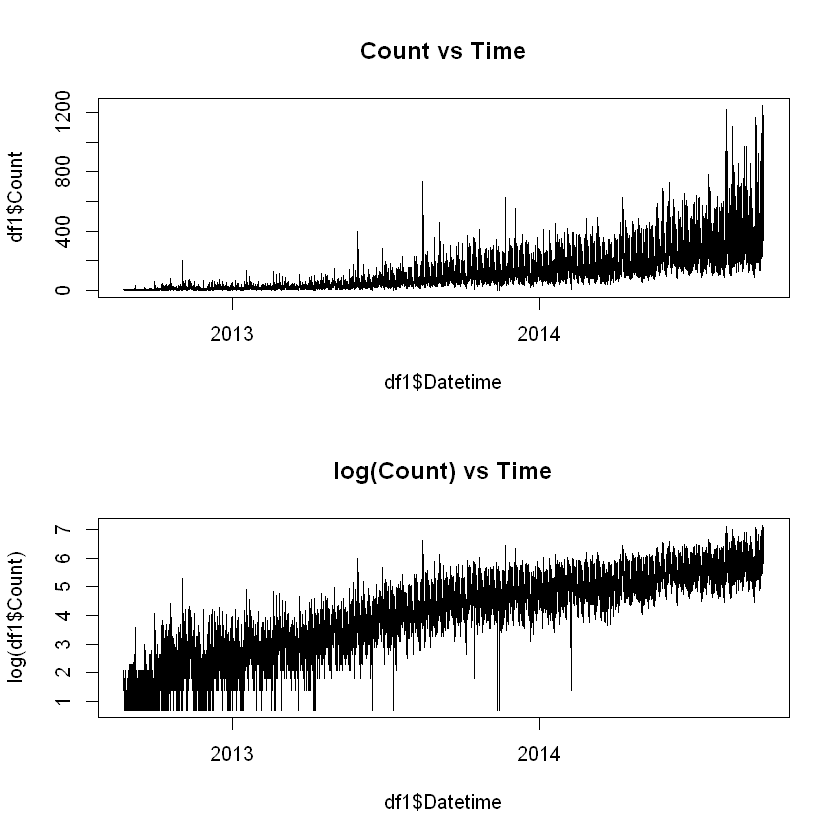

In [4]:
par(mfrow=c(2,1))
plot(df1$Datetime,df1$Count, type='l', main = 'Count vs Time')
plot(df1$Datetime,log(df1$Count), type='l', main = 'log(Count) vs Time')

Partial autocorrelation shows strongest seasonality with period of 1 day and 7 days.

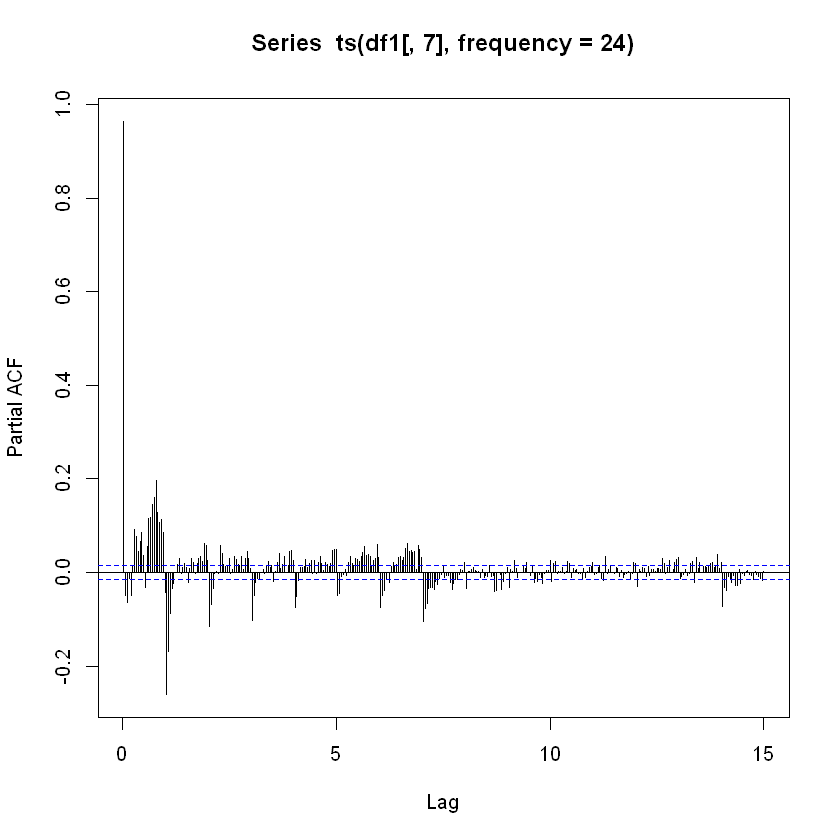

In [5]:
TS <- ts(df1[,7],frequency=168)
pacf(ts(df1[,7],frequency=24),lag=360)

Plotting of the geometric mean of the passenger count grouped by hour of the day and day of the week shows seasonal trends.

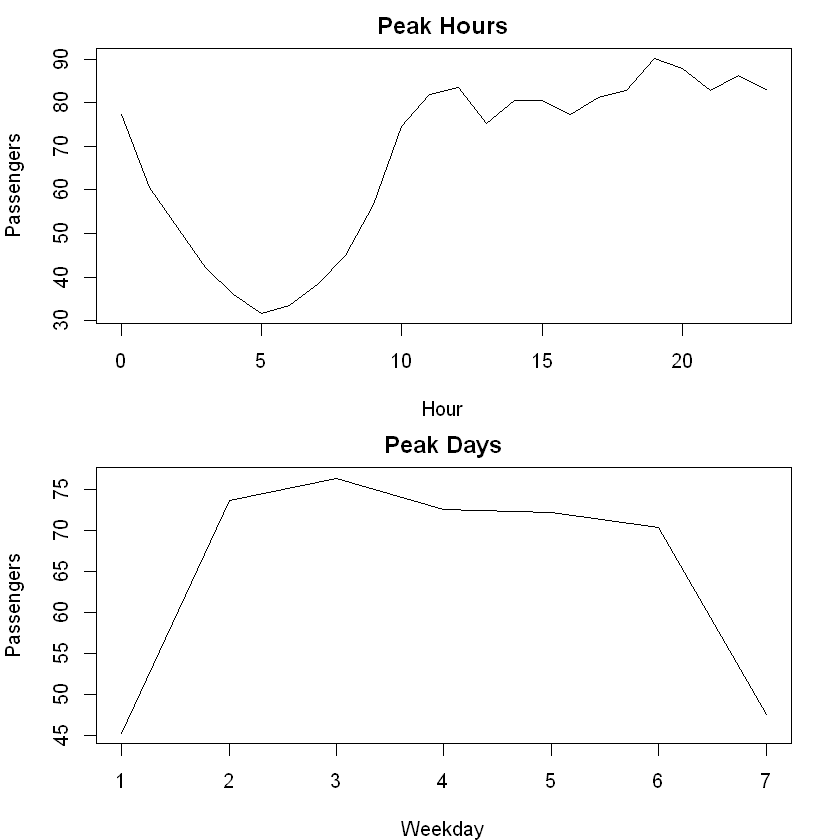

In [6]:
par(mfrow=c(2,1),mar=c(4,4,2,2))
plot(0:23,aggregate(df1$Count,list(df1$hr),geoMean)[,2], type='l',xlab='Hour',ylab='Passengers',main='Peak Hours')
plot(1:7,aggregate(df1$Count,list(df1$wd),geoMean)[,2], type='l',xlab='Weekday',ylab='Passengers',main ='Peak Days')

There are the fewest passengers in the early morning, and on Saturdays and Sundays.


## Time Series Decomposition

The time series is decomposed into trend, seasonality, and noise as follows.

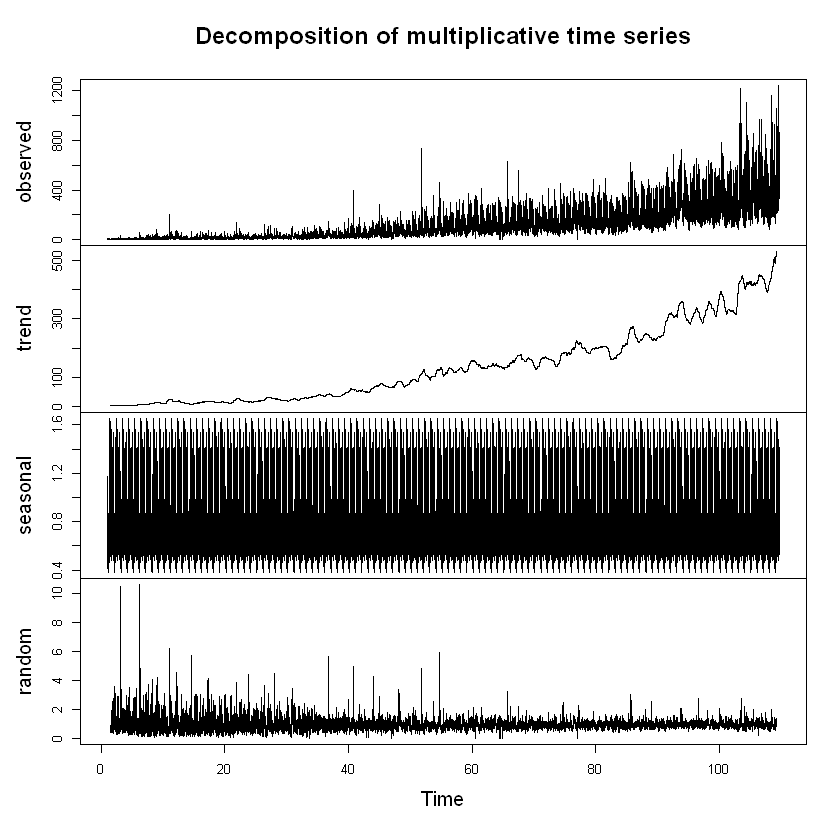

In [7]:
decomposedTS <- decompose(TS,type='mult')
plot(decomposedTS)

A table of the three components is generated.

In [8]:
stlTS <- stl(log(TS),s.window='periodic')
components <- exp(stlTS$time.series)
head(components,10)

seasonal,trend,remainder
1.2736905,3.224755,1.9477329
1.0090744,3.217392,0.6160314
0.8224904,3.210046,2.2725276
0.6620160,3.202717,0.9432851
0.5498908,3.195404,1.1382241
0.4604410,3.188109,1.3624573
0.4437631,3.180829,1.4168976
0.4971437,3.173567,1.2676531
0.5680883,3.166321,3.3356500
0.6607981,3.159092,0.9580738


Then the remainder is checked to see if it is stationary.

In [9]:
stationaryTS <- components[,3]
trendTS <- components[,2]
seasonTS <- components[,1]
adf.test(stationaryTS,30)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
      lag    ADF p.value
 [1,]   0 -26.26    0.01
 [2,]   1 -17.64    0.01
 [3,]   2 -14.32    0.01
 [4,]   3 -12.11    0.01
 [5,]   4 -10.71    0.01
 [6,]   5 -10.07    0.01
 [7,]   6  -9.47    0.01
 [8,]   7  -8.78    0.01
 [9,]   8  -8.27    0.01
[10,]   9  -7.73    0.01
[11,]  10  -7.32    0.01
[12,]  11  -7.04    0.01
[13,]  12  -6.79    0.01
[14,]  13  -6.61    0.01
[15,]  14  -6.38    0.01
[16,]  15  -6.10    0.01
[17,]  16  -5.87    0.01
[18,]  17  -5.71    0.01
[19,]  18  -5.52    0.01
[20,]  19  -5.31    0.01
[21,]  20  -5.05    0.01
[22,]  21  -4.96    0.01
[23,]  22  -4.85    0.01
[24,]  23  -4.69    0.01
[25,]  24  -4.59    0.01
[26,]  25  -4.64    0.01
[27,]  26  -4.53    0.01
[28,]  27  -4.58    0.01
[29,]  28  -4.52    0.01
[30,]  29  -4.55    0.01
Type 2: with drift no trend 
      lag   ADF p.value
 [1,]   0 -72.3    0.01
 [2,]   1 -51.6    0.01
 [3,]   2 -43.7    0.01
 [4,]   3 -38.3 

The p values are <0.05, indicating the remainder is stationary and can be modeled with ARIMA.

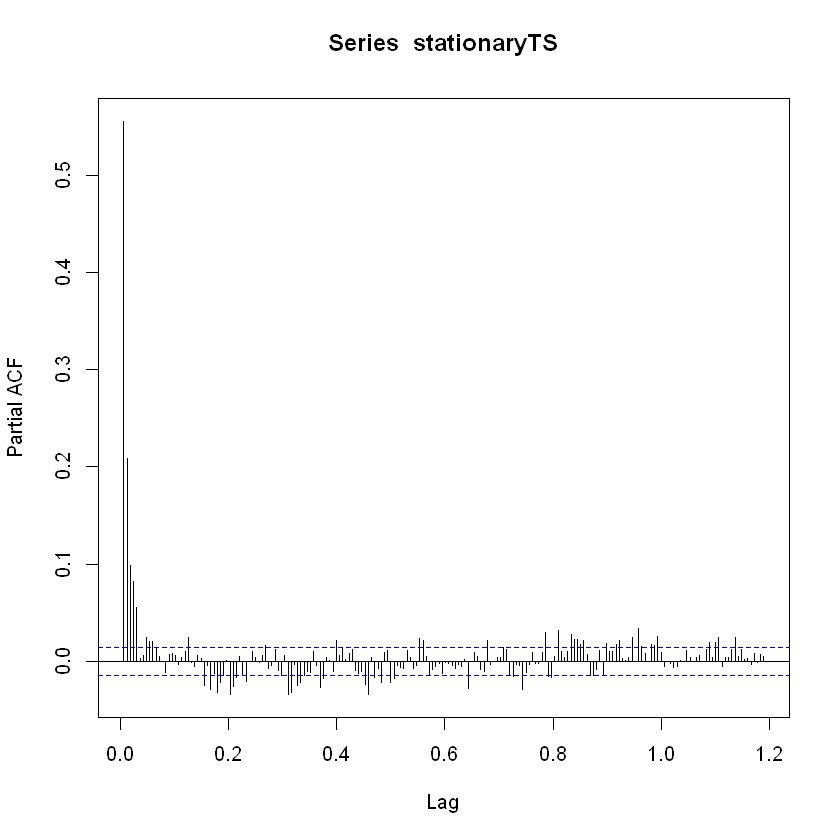

In [10]:
pacf(stationaryTS,200)

The partial autocorrelation plot (x axis is in weeks) shows no large correlations except at small lag times. This means most of the seasonality has been removed during decomposition.

## Time Series Modeling

The ARIMA order parameters are determined automatically below for the stationary component.

Series: stationaryTS 
ARIMA(2,1,1) 

Coefficients:
         ar1     ar2      ma1
      0.3663  0.1428  -0.9305
s.e.  0.0112  0.0102   0.0077

sigma^2 estimated as 0.1499:  log likelihood=-8596.8
AIC=17201.61   AICc=17201.61   BIC=17232.86

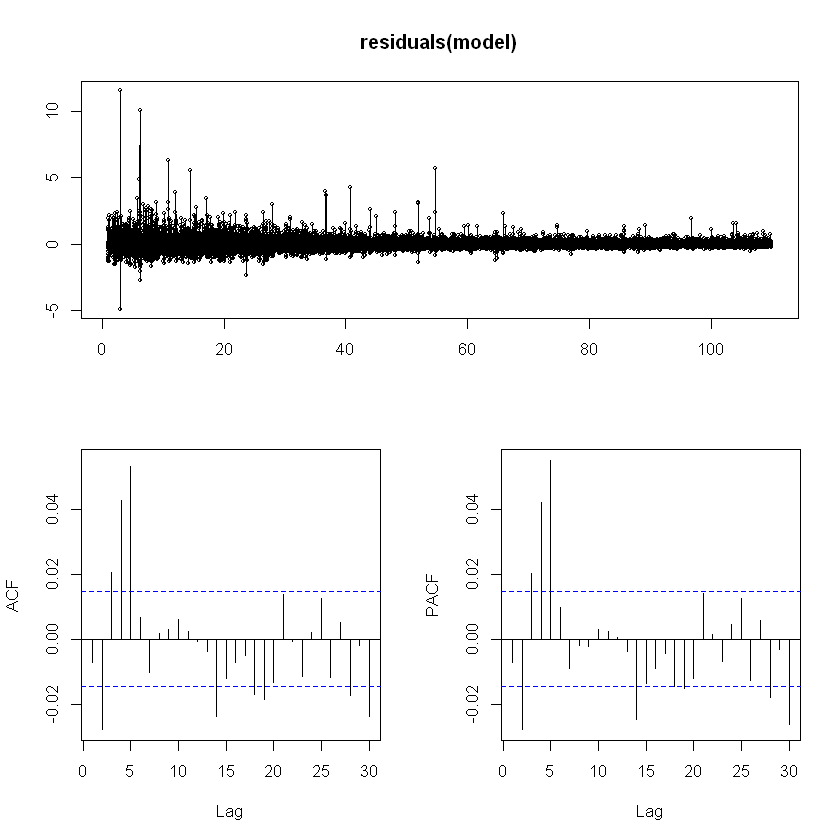

In [11]:
model <- auto.arima(stationaryTS, seasonal=FALSE)
model
tsdisplay(residuals(model),lag.max=30)

Once again, the PACF (x in hours) shows no daily seasonality (no peaks at 24 hours).

The ARIMA model is used to forecast the noise.

Forecast for univariate time series: 
      Lead Forecast   S.E    Lower Upper
18289    1    0.847 0.387  0.08852  1.61
18290    2    0.889 0.422  0.06140  1.72
18291    3    0.922 0.446  0.04714  1.80
18292    4    0.940 0.458  0.04170  1.84
18293    5    0.951 0.466  0.03740  1.86
18294    6    0.957 0.472  0.03290  1.88
18295    7    0.962 0.476  0.02797  1.90
18296    8    0.964 0.480  0.02265  1.91
18297    9    0.965 0.484  0.01707  1.91
18298   10    0.966 0.487  0.01134  1.92
18299   11    0.967 0.490  0.00552  1.93
18300   12    0.967 0.494 -0.00034  1.93
18301   13    0.967 0.497 -0.00621  1.94
18302   14    0.967 0.500 -0.01208  1.95
18303   15    0.968 0.503 -0.01793  1.95
18304   16    0.968 0.506 -0.02376  1.96
18305   17    0.968 0.509 -0.02955  1.96
18306   18    0.968 0.512 -0.03532  1.97
18307   19    0.968 0.515 -0.04106  1.98
18308   20    0.968 0.518 -0.04677  1.98
18309   21    0.968 0.520 -0.05245  1.99
18310   22    0.968 0.523 -0.05809  1.99
18311   23    0.968

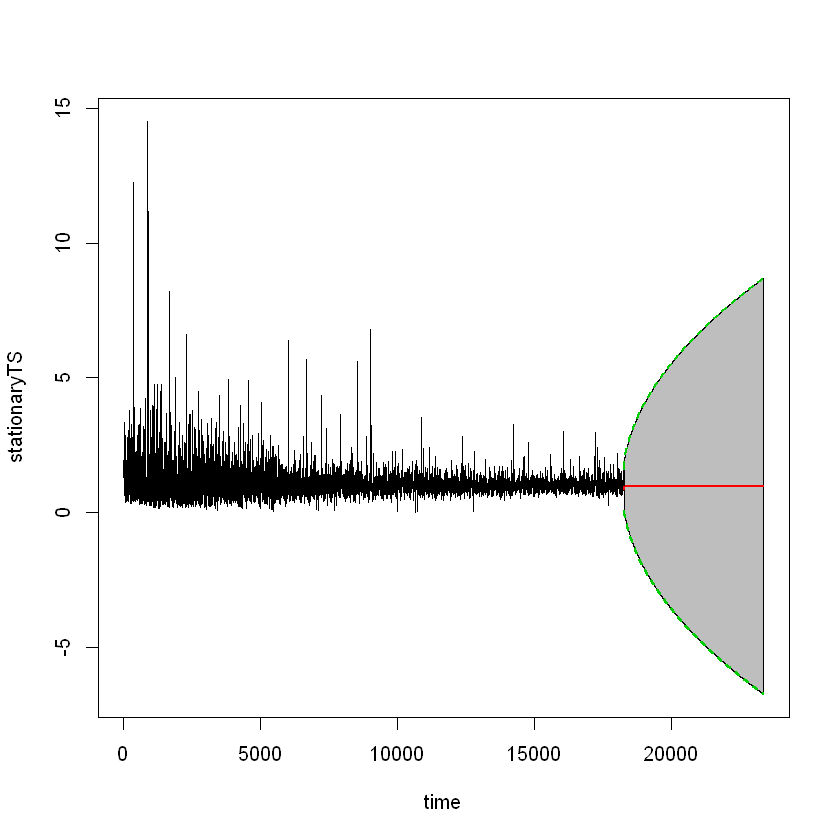

In [12]:
model <- arima(stationaryTS, order =c(2,1,1))
prediction <- forecast(model,5112)

Next, the trend component is modeled using non-linear least squares regression (a simple exponential model).

[1] "double"

Warning message in nls(trendTS ~ b * (a^t)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"

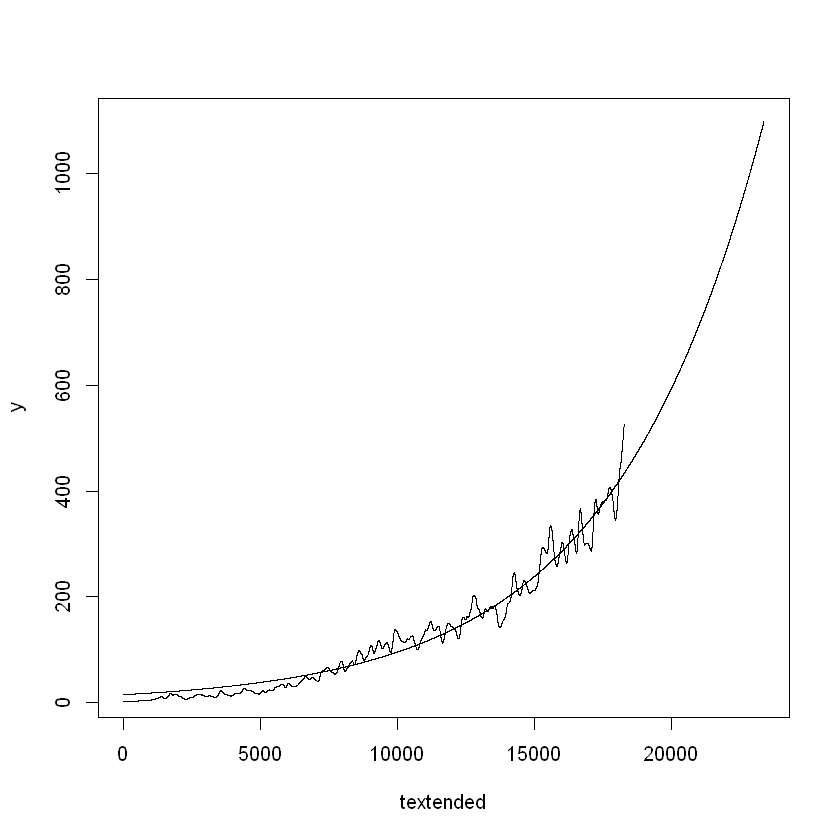

In [13]:
t <- 1:length(trendTS)
typeof(trendTS)
expmodel <- nls(trendTS~b*(a^t))
A<-coef(expmodel)[[2]]
B<-coef(expmodel)[[1]]
textended <-1:(length(trendTS)+5112)
y <- B*(A^textended)
plot(textended,y,type='l')
lines(t,trendTS)

Finally, the seasonality component can be forecasted by just cycling through it repeatedly. However, first it must be determined at which point in the cycle the data starts and ends.

In [14]:
head(df1,10)
tail(df1,10)

ID,d,m,y,hr,min,Count,Datetime,wd
0,25,8,2012,0,0,8,2012-08-25 00:00:00,7
1,25,8,2012,1,0,2,2012-08-25 01:00:00,7
2,25,8,2012,2,0,6,2012-08-25 02:00:00,7
3,25,8,2012,3,0,2,2012-08-25 03:00:00,7
4,25,8,2012,4,0,2,2012-08-25 04:00:00,7
5,25,8,2012,5,0,2,2012-08-25 05:00:00,7
6,25,8,2012,6,0,2,2012-08-25 06:00:00,7
7,25,8,2012,7,0,2,2012-08-25 07:00:00,7
8,25,8,2012,8,0,6,2012-08-25 08:00:00,7
9,25,8,2012,9,0,2,2012-08-25 09:00:00,7


,ID,d,m,y,hr,min,Count,Datetime,wd
18279,18278,25,9,2014,14,0,616,2014-09-25 14:00:00,5
18280,18279,25,9,2014,15,0,686,2014-09-25 15:00:00,5
18281,18280,25,9,2014,16,0,654,2014-09-25 16:00:00,5
18282,18281,25,9,2014,17,0,622,2014-09-25 17:00:00,5
18283,18282,25,9,2014,18,0,680,2014-09-25 18:00:00,5
18284,18283,25,9,2014,19,0,868,2014-09-25 19:00:00,5
18285,18284,25,9,2014,20,0,732,2014-09-25 20:00:00,5
18286,18285,25,9,2014,21,0,702,2014-09-25 21:00:00,5
18287,18286,25,9,2014,22,0,580,2014-09-25 22:00:00,5
18288,18287,25,9,2014,23,0,534,2014-09-25 23:00:00,5


The cycle length is 24 x 7 = 168 hours (data points) long. It begins on a Saturday, and the data ends on a Thursday. Therefore the repeated cycle must start on a Friday (the last 24 hours of the 168 hour cycle) and run until the 144th hour of the cycle.

Then the stationary noise, trend, and seasonality components can be multiplied together to generate the final prediction. But, first the model will be evaluated against actual data.

[1] "RMSE"

[1] 41.71604

[1] "R^2"

[1] 0.9268111

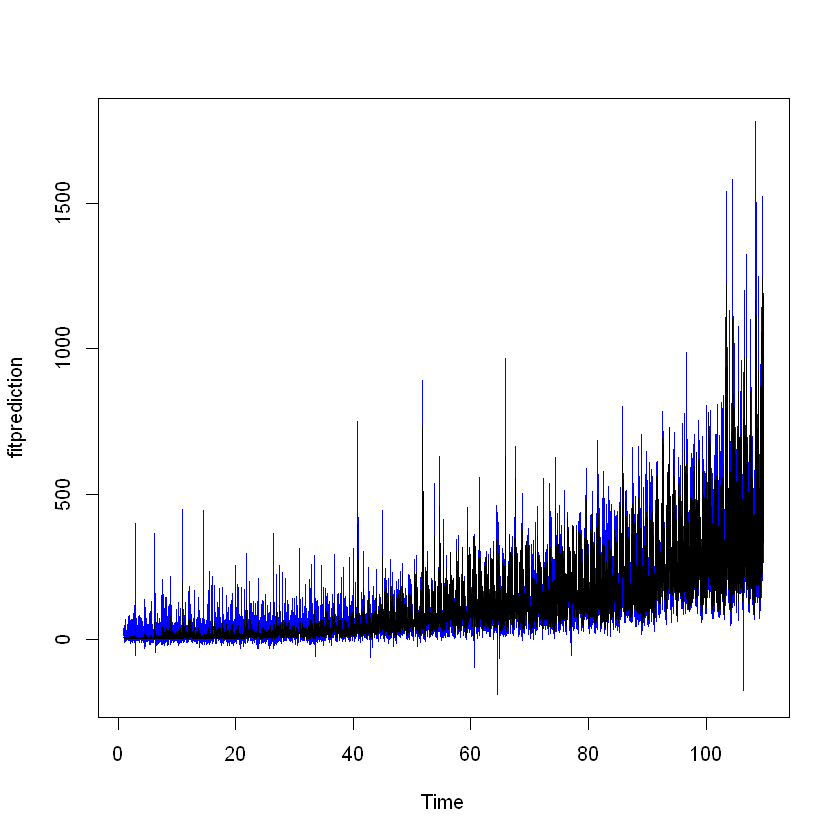

In [87]:
tfit <-1:length(trendTS)
stationaryfit <-residuals(model)+stationaryTS
fitprediction <- B*(A^tfit)*stationaryfit*seasonTS
plot(fitprediction,type='l',col='blue')
lines(TS)
'RMSE'
sqrt(sum((fitprediction-TS)^2)/(length(TS)-(168+2+4)))
'R^2'
1-sum((fitprediction-TS)^2)/sum((TS-mean(TS))^2)

The fit is decent. We will continue generating the prediction using this model.

Warning message in B * (A^tforecast) * prediction[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B * (A^tforecast) * prediction[, 2] * shiftedseason:
"longer object length is not a multiple of shorter object length"

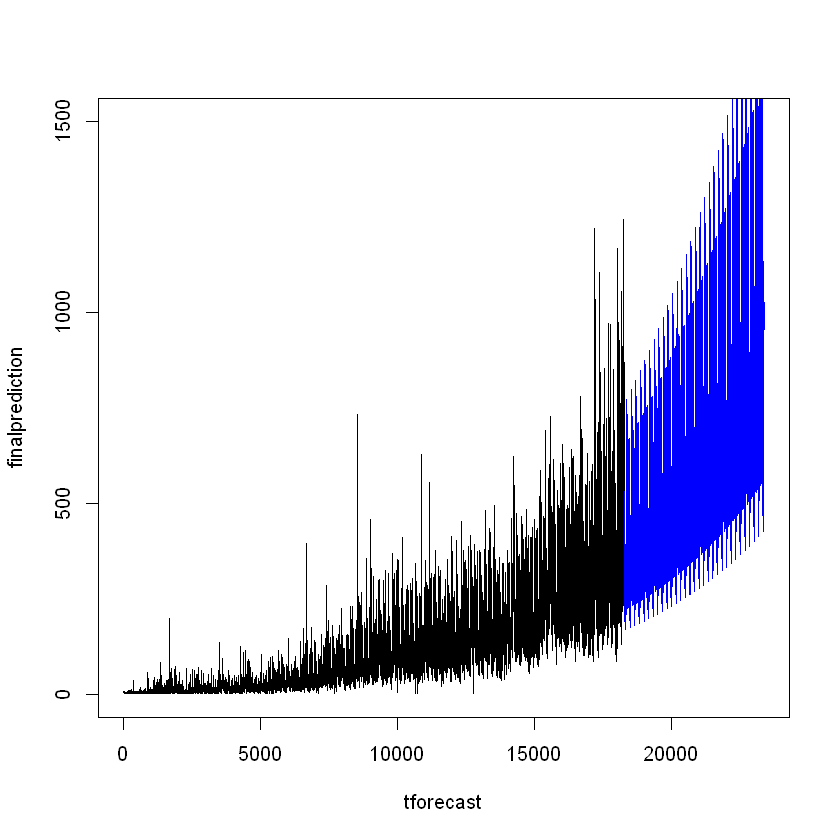

In [15]:
shiftedseason <- c(tail(seasonTS,24),seasonTS[1:144])

tforecast <-length(trendTS):(length(trendTS)+5112)

finalprediction <- B*(A^tforecast)*prediction[,2]*shiftedseason

plot(tforecast,finalprediction,type='l',xlim=c(0,23399),ylim=c(0,1500),col='blue')
lines(df$ID,df$Count)

In [16]:
forecasttable <- as.data.frame(tforecast)
forecasttable$predict <- finalprediction
write.csv(forecasttable,'C:/Datasets/TrafficPredict.csv')

## Cross Validation

Cross validation is be performed using subsets of the full data set as the training set and subsequent data points as the test set. The test set size is approximately half the training set size. The training set always starts at the beginning of the full data set. Cross validation is performed with 7 different splits, with the training set representing ~ 10, 20, 30,... 70% of the total data set respectively, where the test set is 5, 10, 15, ... 35% of the total data set that immediately follows the training set.

All the procedures performed above using the full set are written as a function.

In [120]:
CV <-function(dftrain, dftest){
    TS2 <- ts(dftrain,frequency=168)
    stlTS2 <- stl(log(TS2),s.window='periodic')
    components2 <- exp(stlTS2$time.series)
    stationaryTS2 <<- components2[,3]
    trendTS2 <- components2[,2]
    seasonTS2 <- components2[,1]

    model2 <- arima(stationaryTS2, order =c(2,1,1),)
    prediction2 <- forecast(model2,length(dftest))
    
    t2 <- 1:length(trendTS2)
    expmodel2 <- nls(trendTS2~b*(a^t2))
    A2 <-coef(expmodel2)[[2]]
    B2 <-coef(expmodel2)[[1]]
    
    shiftedseason2 <- c(tail(seasonTS2,24),seasonTS2[1:144])
    tforecast2 <-length(trendTS2):(length(trendTS2)+length(dftest))
    finalprediction2 <- B2*(A2^tforecast2)*prediction2[,2]*shiftedseason2
    plot(finalprediction2,type='l',col='blue')
    lines(dftest)
    return(c((sqrt(sum((finalprediction2-dftest)^2)/(length(dftest)-168-4-2))),(1-sum((finalprediction2-dftest)^2)/sum((dftest-mean(dftest))^2))))
}

Cross validation is performed as follows. The number of samples int he training set follows a formula that ensures the weekdays are aligned the same way in the training sets as they are in the full set (start on Sunday, end on Thrusday).

Forecast for univariate time series: 
     Lead Forecast   S.E  Lower Upper
1825    1     1.01 0.664 -0.296  2.31
1826    2     1.06 0.710 -0.335  2.45
1827    3     1.10 0.746 -0.366  2.56
1828    4     1.12 0.758 -0.365  2.61
1829    5     1.14 0.765 -0.360  2.64
1830    6     1.15 0.767 -0.354  2.65
1831    7     1.16 0.769 -0.348  2.67
1832    8     1.16 0.769 -0.344  2.67
1833    9     1.17 0.770 -0.341  2.68
1834   10     1.17 0.770 -0.339  2.68
1835   11     1.17 0.770 -0.337  2.68
1836   12     1.17 0.770 -0.336  2.68
1837   13     1.17 0.770 -0.335  2.68
1838   14     1.17 0.770 -0.335  2.68
1839   15     1.17 0.770 -0.334  2.68
1840   16     1.17 0.770 -0.334  2.68
1841   17     1.17 0.770 -0.334  2.68
1842   18     1.17 0.770 -0.334  2.68
1843   19     1.18 0.770 -0.334  2.68
1844   20     1.18 0.770 -0.334  2.68
1845   21     1.18 0.770 -0.334  2.68
1846   22     1.18 0.770 -0.334  2.68
1847   23     1.18 0.770 -0.334  2.68
1848   24     1.18 0.770 -0.334  2.68
1849   25   

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

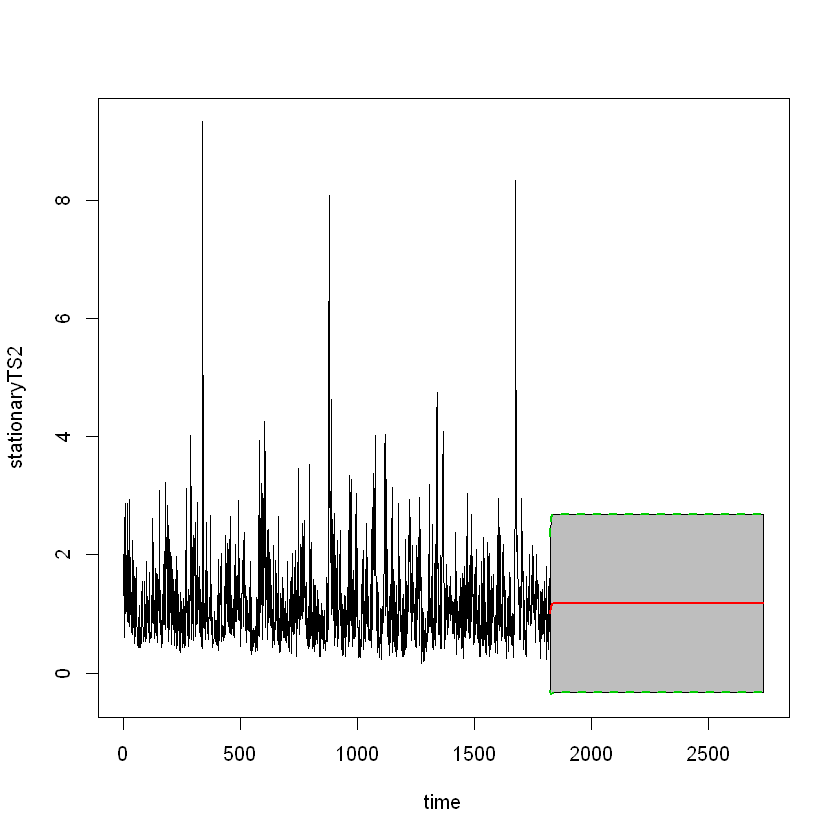

Forecast for univariate time series: 
     Lead Forecast   S.E   Lower Upper
3505    1     1.92 0.629  0.6858  3.15
3506    2     1.58 0.670  0.2633  2.89
3507    3     1.47 0.703  0.0887  2.84
3508    4     1.36 0.713 -0.0413  2.76
3509    5     1.29 0.719 -0.1139  2.70
3510    6     1.25 0.721 -0.1628  2.66
3511    7     1.22 0.722 -0.1935  2.64
3512    8     1.20 0.722 -0.2138  2.62
3513    9     1.19 0.723 -0.2271  2.61
3514   10     1.18 0.723 -0.2358  2.60
3515   11     1.17 0.723 -0.2416  2.59
3516   12     1.17 0.723 -0.2455  2.59
3517   13     1.17 0.723 -0.2480  2.59
3518   14     1.17 0.723 -0.2497  2.58
3519   15     1.17 0.723 -0.2508  2.58
3520   16     1.17 0.723 -0.2516  2.58
3521   17     1.16 0.723 -0.2521  2.58
3522   18     1.16 0.723 -0.2524  2.58
3523   19     1.16 0.723 -0.2526  2.58
3524   20     1.16 0.723 -0.2528  2.58
3525   21     1.16 0.723 -0.2529  2.58
3526   22     1.16 0.723 -0.2530  2.58
3527   23     1.16 0.723 -0.2530  2.58
3528   24     1.16 0.723 -

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

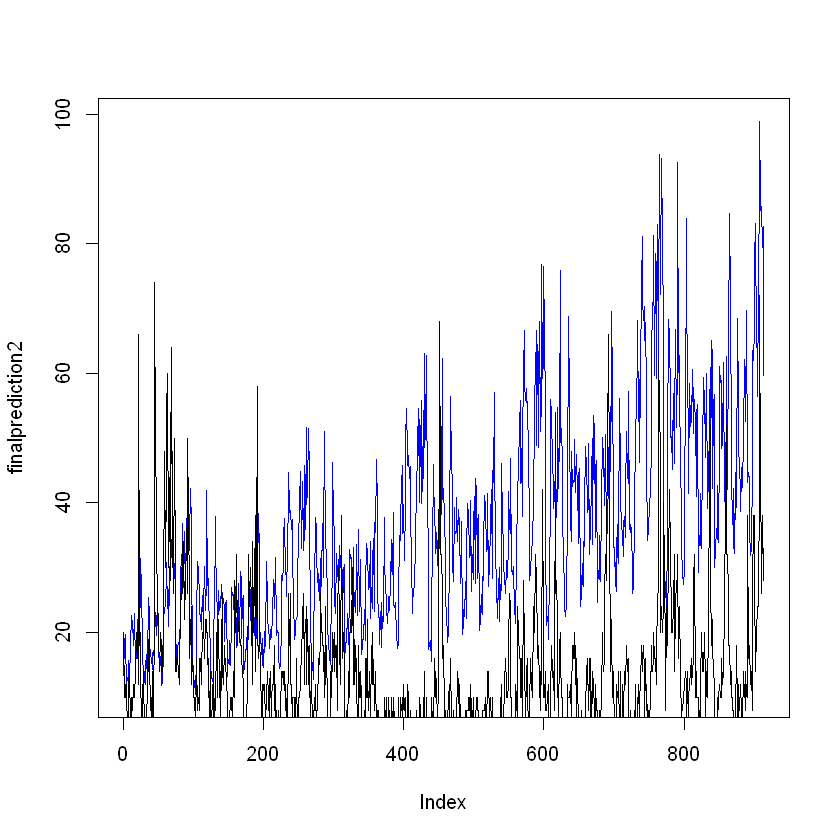

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

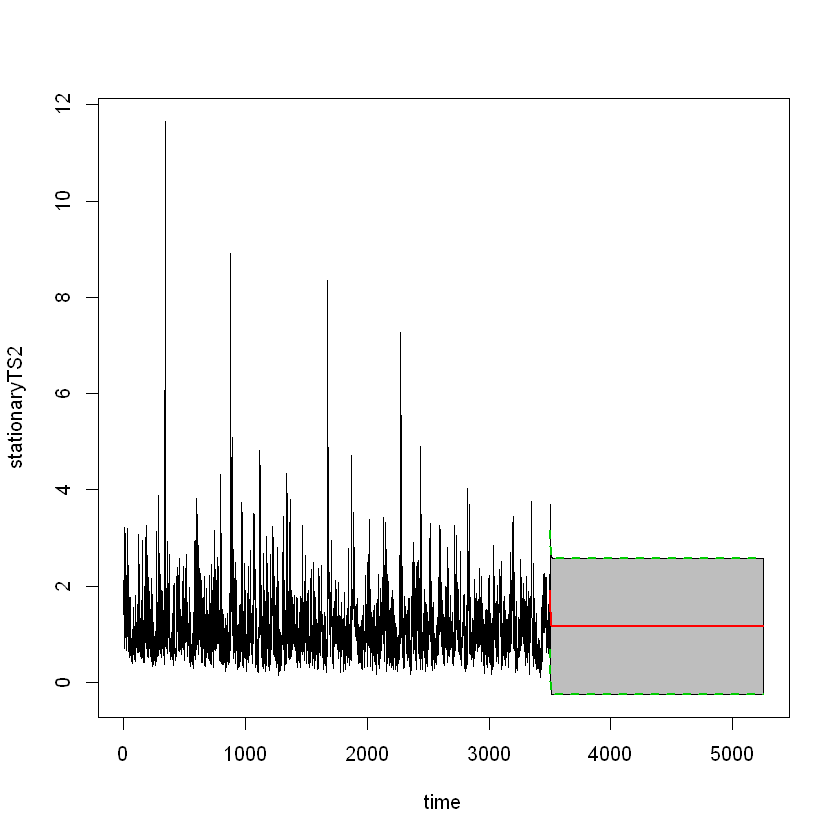

Forecast for univariate time series: 
     Lead Forecast   S.E    Lower Upper
5185    1     1.56 0.586  0.40780  2.71
5186    2     1.47 0.629  0.24142  2.71
5187    3     1.41 0.659  0.11448  2.70
5188    4     1.37 0.673  0.05411  2.69
5189    5     1.35 0.683  0.01567  2.69
5190    6     1.34 0.690 -0.00895  2.70
5191    7     1.34 0.696 -0.02671  2.70
5192    8     1.33 0.701 -0.04058  2.71
5193    9     1.33 0.707 -0.05232  2.72
5194   10     1.33 0.711 -0.06285  2.73
5195   11     1.33 0.716 -0.07268  2.73
5196   12     1.33 0.721 -0.08210  2.74
5197   13     1.33 0.725 -0.09127  2.75
5198   14     1.33 0.730 -0.10027  2.76
5199   15     1.33 0.734 -0.10916  2.77
5200   16     1.33 0.739 -0.11796  2.78
5201   17     1.33 0.743 -0.12668  2.79
5202   18     1.33 0.748 -0.13535  2.80
5203   19     1.33 0.752 -0.14396  2.80
5204   20     1.33 0.756 -0.15251  2.81
5205   21     1.33 0.761 -0.16102  2.82
5206   22     1.33 0.765 -0.16947  2.83
5207   23     1.33 0.769 -0.17788  2.84
52

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

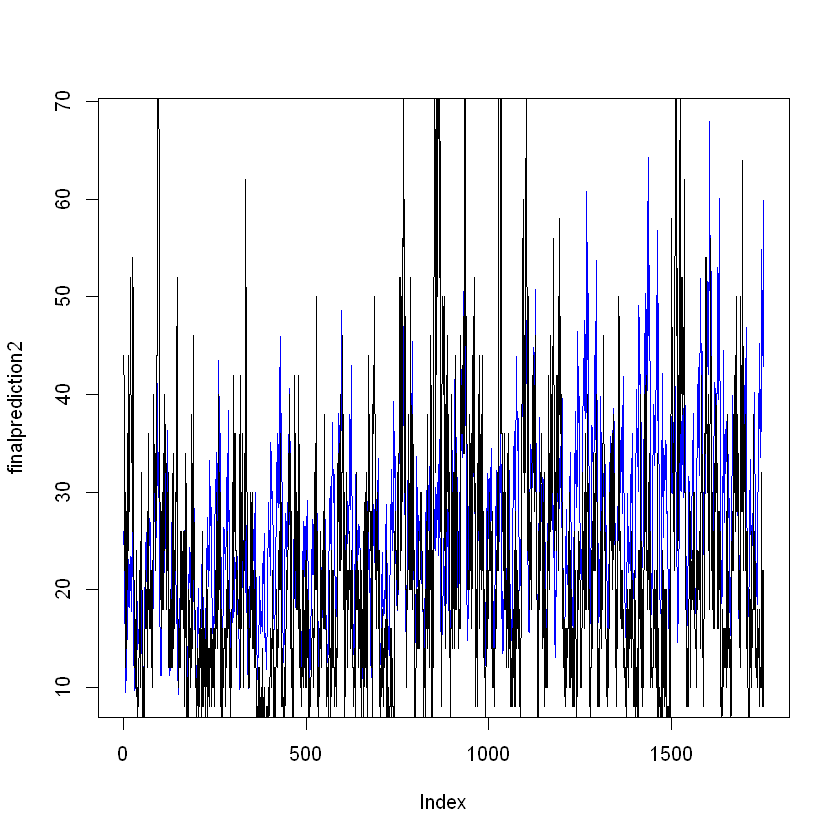

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

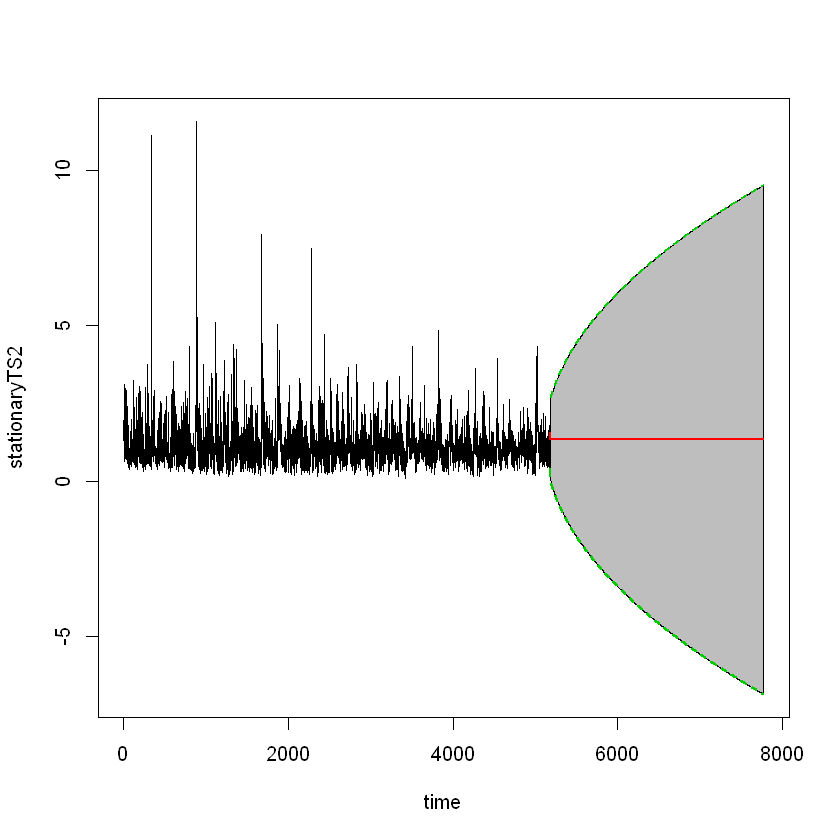

Forecast for univariate time series: 
      Lead Forecast   S.E    Lower Upper
6865     1     1.17 0.551  0.09410  2.25
6866     2     1.23 0.593  0.07129  2.39
6867     3     1.28 0.620  0.06437  2.50
6868     4     1.30 0.634  0.06005  2.55
6869     5     1.32 0.643  0.05463  2.58
6870     6     1.32 0.651  0.04747  2.60
6871     7     1.33 0.657  0.03925  2.61
6872     8     1.33 0.662  0.03039  2.63
6873     9     1.33 0.668  0.02119  2.64
6874    10     1.33 0.673  0.01183  2.65
6875    11     1.33 0.678  0.00241  2.66
6876    12     1.33 0.683 -0.00702  2.67
6877    13     1.33 0.688 -0.01642  2.68
6878    14     1.33 0.692 -0.02577  2.69
6879    15     1.33 0.697 -0.03507  2.70
6880    16     1.33 0.702 -0.04432  2.71
6881    17     1.33 0.707 -0.05351  2.72
6882    18     1.33 0.711 -0.06264  2.73
6883    19     1.33 0.716 -0.07171  2.73
6884    20     1.33 0.720 -0.08073  2.74
6885    21     1.33 0.725 -0.08968  2.75
6886    22     1.33 0.730 -0.09859  2.76
6887    23     1.33

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

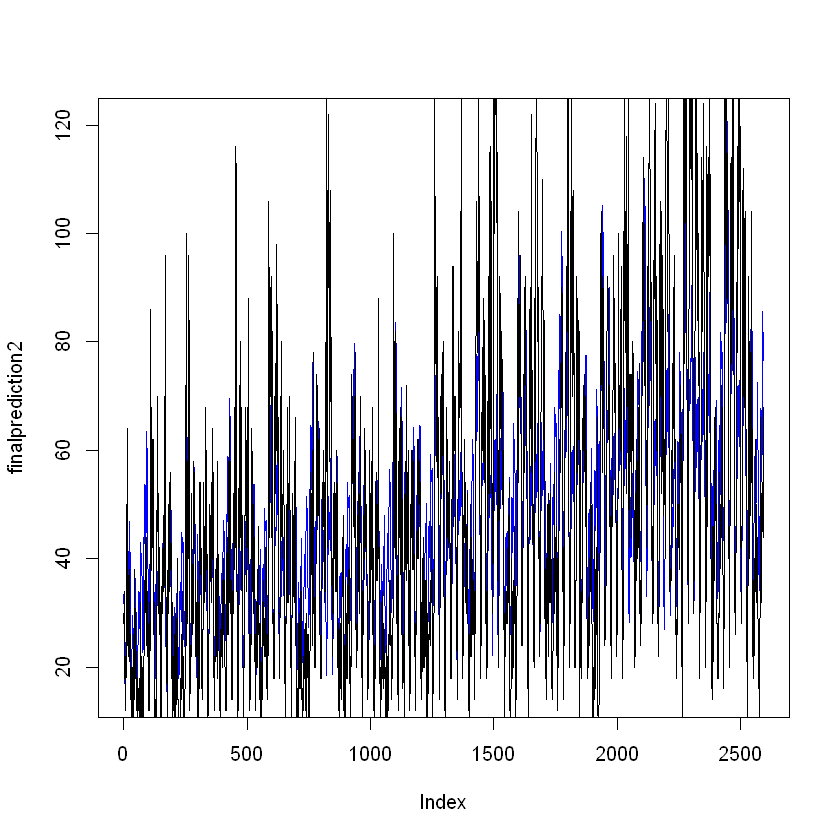

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

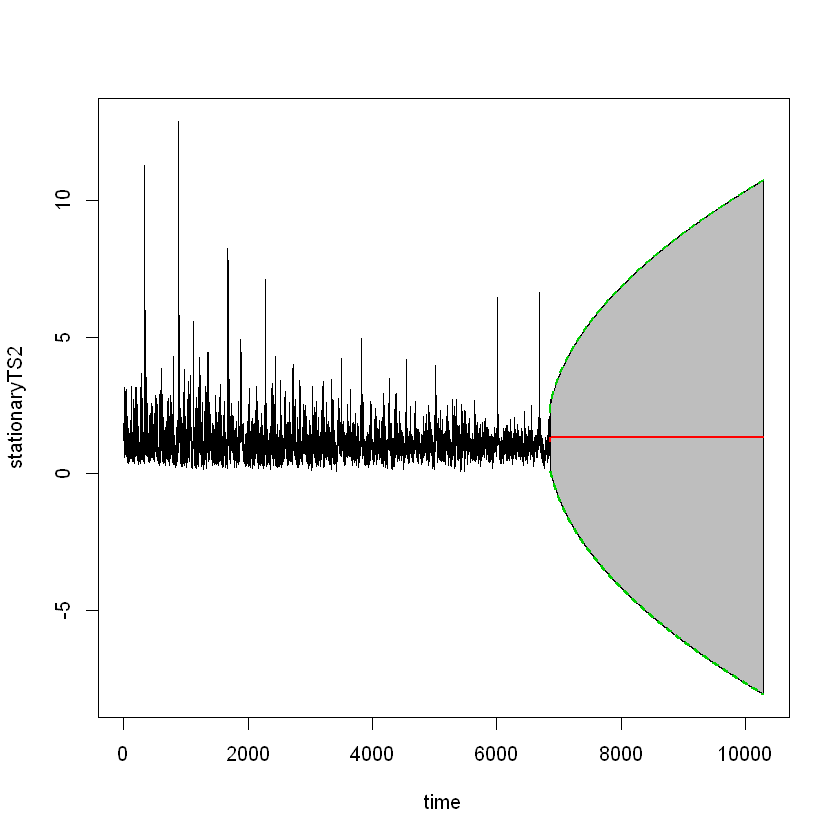

Forecast for univariate time series: 
      Lead Forecast   S.E     Lower Upper
8545     1     3.31 0.513  2.305138  4.32
8546     2     2.86 0.554  1.774471  3.95
8547     3     2.47 0.582  1.330647  3.61
8548     4     2.29 0.596  1.117865  3.45
8549     5     2.17 0.605  0.988029  3.36
8550     6     2.11 0.612  0.913548  3.31
8551     7     2.08 0.618  0.867544  3.29
8552     8     2.06 0.623  0.837932  3.28
8553     9     2.05 0.628  0.817370  3.28
8554    10     2.04 0.633  0.801918  3.28
8555    11     2.04 0.638  0.789343  3.29
8556    12     2.04 0.642  0.778405  3.30
8557    13     2.04 0.647  0.768408  3.30
8558    14     2.04 0.652  0.758965  3.31
8559    15     2.04 0.656  0.749856  3.32
8560    16     2.04 0.660  0.740961  3.33
8561    17     2.04 0.665  0.732210  3.34
8562    18     2.04 0.669  0.723563  3.35
8563    19     2.04 0.674  0.714999  3.36
8564    20     2.04 0.678  0.706505  3.36
8565    21     2.04 0.682  0.698073  3.37
8566    22     2.04 0.686  0.689699  3

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

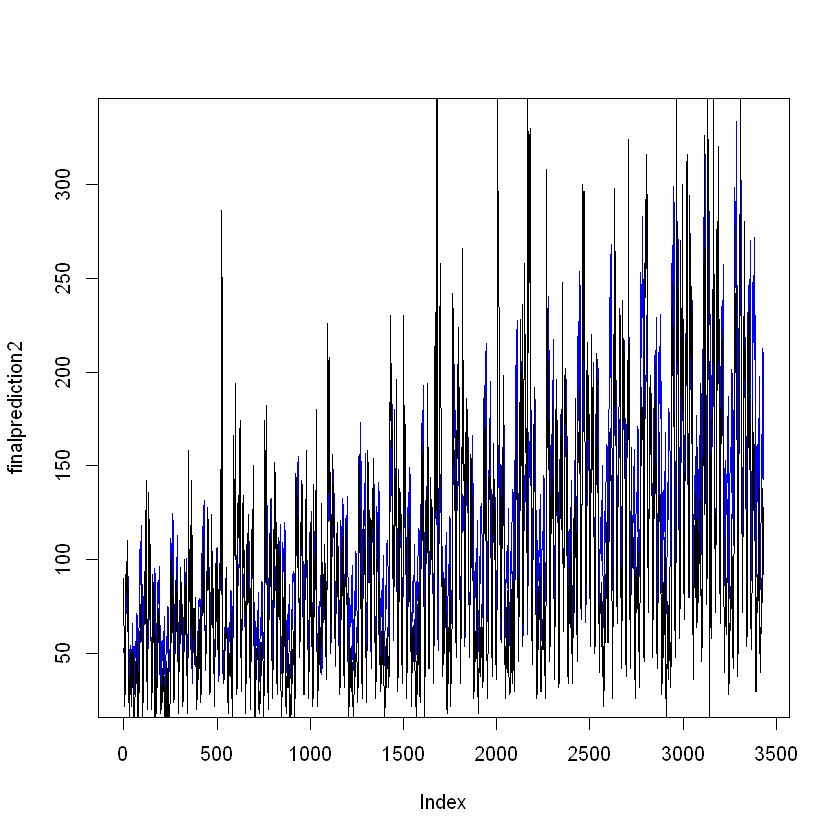

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

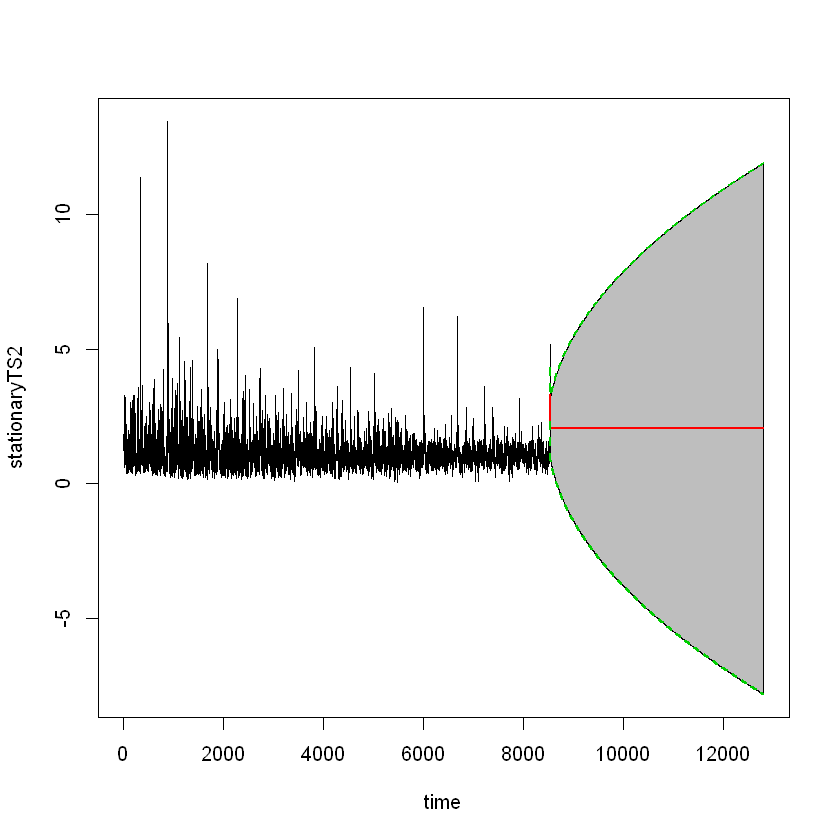

Forecast for univariate time series: 
      Lead Forecast   S.E    Lower Upper
10225    1    0.949 0.486 -0.00356  1.90
10226    2    0.972 0.527 -0.06103  2.01
10227    3    0.987 0.554 -0.09927  2.07
10228    4    0.995 0.568 -0.11801  2.11
10229    5    1.000 0.577 -0.13170  2.13
10230    6    1.002 0.584 -0.14293  2.15
10231    7    1.004 0.590 -0.15309  2.16
10232    8    1.004 0.595 -0.16269  2.17
10233    9    1.005 0.600 -0.17198  2.18
10234   10    1.005 0.605 -0.18108  2.19
10235   11    1.005 0.610 -0.19005  2.20
10236   12    1.005 0.614 -0.19891  2.21
10237   13    1.005 0.619 -0.20768  2.22
10238   14    1.005 0.623 -0.21639  2.23
10239   15    1.005 0.628 -0.22503  2.24
10240   16    1.005 0.632 -0.23360  2.24
10241   17    1.005 0.637 -0.24211  2.25
10242   18    1.005 0.641 -0.25056  2.26
10243   19    1.005 0.645 -0.25896  2.27
10244   20    1.005 0.649 -0.26730  2.28
10245   21    1.005 0.654 -0.27559  2.29
10246   22    1.005 0.658 -0.28382  2.29
10247   23    1.005

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

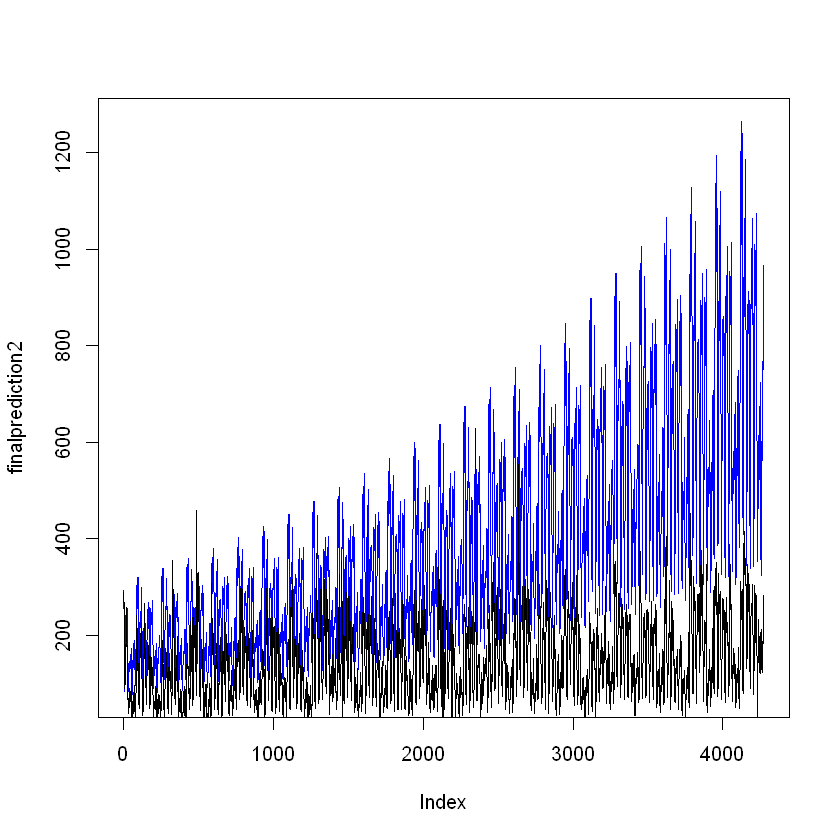

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

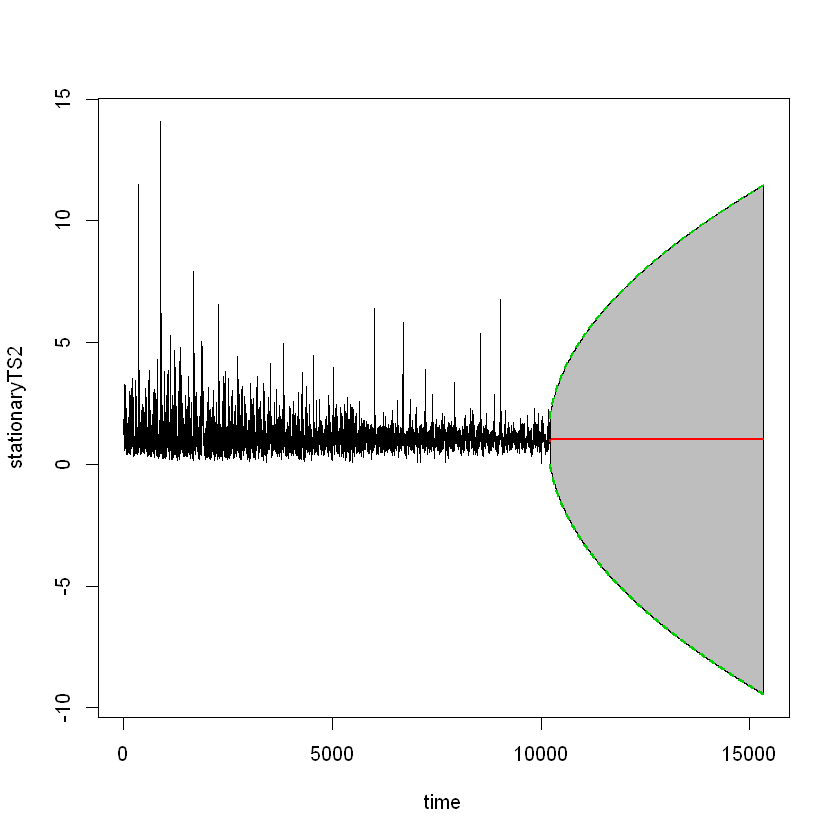

Forecast for univariate time series: 
      Lead Forecast   S.E   Lower Upper
11905    1    0.971 0.460  0.0691  1.87
11906    2    0.969 0.500 -0.0105  1.95
11907    3    0.971 0.526 -0.0603  2.00
11908    4    0.971 0.539 -0.0857  2.03
11909    5    0.972 0.548 -0.1029  2.05
11910    6    0.972 0.555 -0.1157  2.06
11911    7    0.972 0.560 -0.1264  2.07
11912    8    0.972 0.565 -0.1359  2.08
11913    9    0.972 0.570 -0.1447  2.09
11914   10    0.972 0.574 -0.1532  2.10
11915   11    0.972 0.578 -0.1614  2.11
11916   12    0.972 0.582 -0.1694  2.11
11917   13    0.972 0.586 -0.1773  2.12
11918   14    0.972 0.590 -0.1852  2.13
11919   15    0.972 0.594 -0.1929  2.14
11920   16    0.972 0.598 -0.2006  2.14
11921   17    0.972 0.602 -0.2083  2.15
11922   18    0.972 0.606 -0.2159  2.16
11923   19    0.972 0.610 -0.2234  2.17
11924   20    0.972 0.614 -0.2309  2.18
11925   21    0.972 0.618 -0.2384  2.18
11926   22    0.972 0.621 -0.2458  2.19
11927   23    0.972 0.625 -0.2531  2.20
11

Warning message in nls(trendTS2 ~ b * (a^t2)):
"No starting values specified for some parameters.
Initializing 'b', 'a' to '1.'.
Consider specifying 'start' or using a selfStart model"Warning message in B2 * (A2^tforecast2) * prediction2[, 2]:
"longer object length is not a multiple of shorter object length"Warning message in B2 * (A2^tforecast2) * prediction2[, 2] * shiftedseason2:
"longer object length is not a multiple of shorter object length"

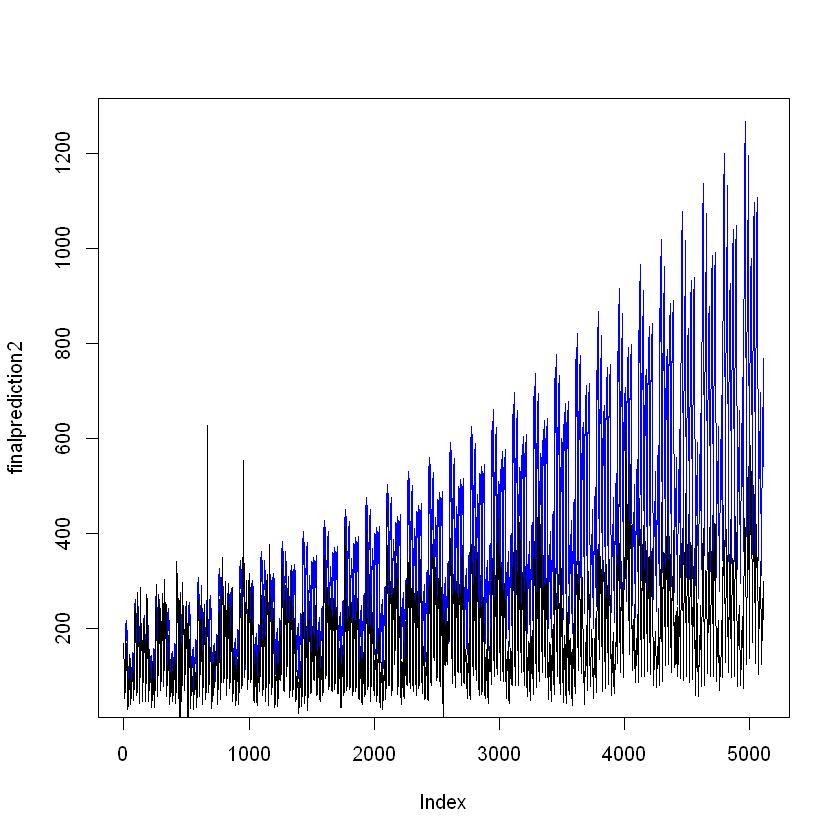

Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"Warning message in finalprediction2 - dftest:
"longer object length is not a multiple of shorter object length"

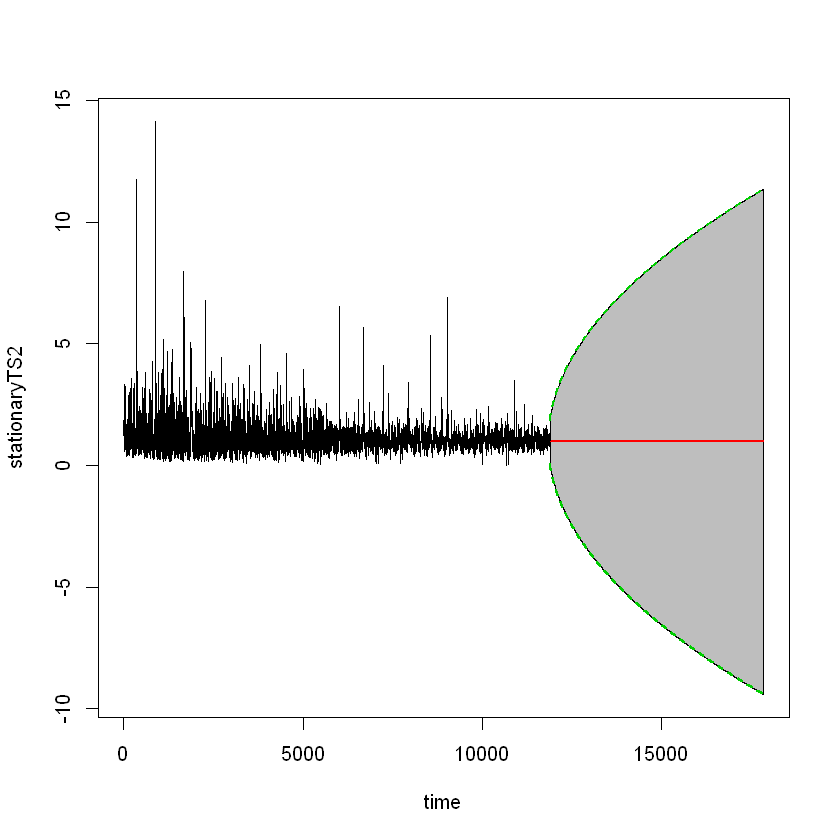

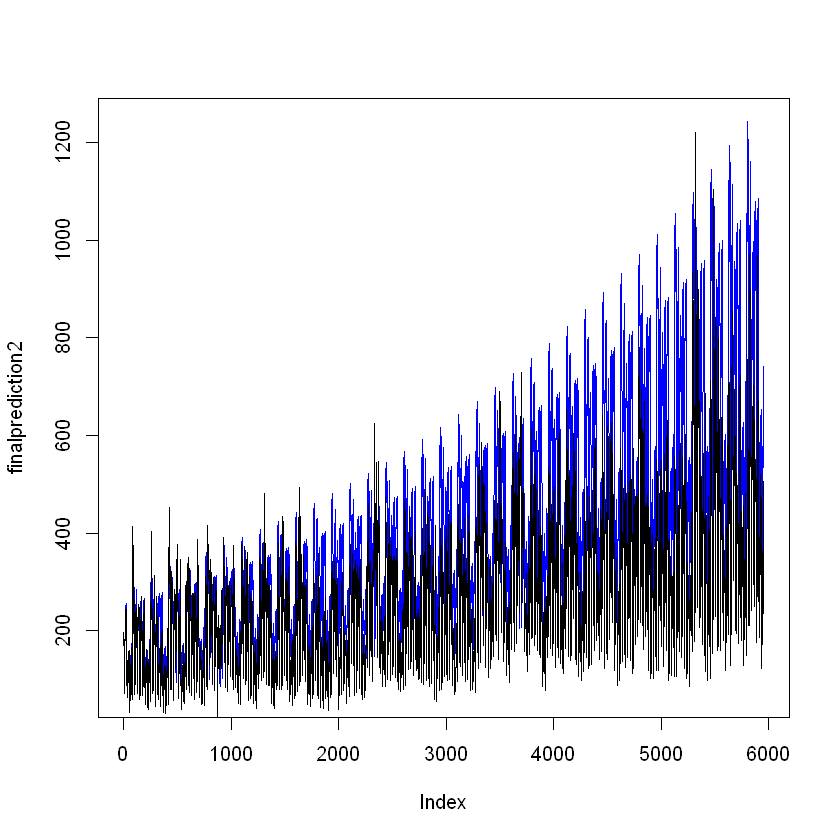

In [129]:
r2<-c()
rmse <- c()
for(i in 1:7){
    number <- i*10*168+144
    scores <- CV(df1[1:number,7],df1[(number+1):(number+1+number%/%2),7])
    rmse <<- append(rmse, scores[1])
    r2 <<- append(r2, scores[2])
}

The results are shown below:

In [130]:
r2

[1]  -5.75552522  -0.03288531   0.45246858   0.49749847 -14.71376223
[6]  -5.75166059  -0.40524417

In [131]:
rmse

[1]  30.82759  15.00129  23.81864  46.54184 313.38981 255.95505 177.61631

The R squared values indicate that the fit is better in the middle than at the beginning or end, where the average of the actual results is a better fit than the forecast. This indicates large range deviations from the model (long range fluctuations), which may be random or may be due to an inadequate trend equation. 

It is evident from the plots of predicted vs actual data that the predictions drift away from the actual data in these cases. For the first CV sets, there likely wasn't enough data to estimate the trend equation, since the data is relatively flat there. For the last CV sets, it looks like the actual behavior starts to deviate from the trend equation, but then starts getting closer to the trend equation at the end.

From the comparison of the trend equation and the actual trend component of the full time series, it is evident that there is some long range (perhaps random) fluctuation, which may be difficult to forecast no matter what equation is used to model the trend. Models with more parameters may make the prediction error worse due to overfitting. Since the current trend model only has 2 paramters and matches the curvature of the data better than a linear model (also 2 parameters) would, the model will not be adjusted any further. In addition, despite the poor R squared values, the current RMSE is still fairly good considering that by the end of the data set the passenger count can fluctuate up to about 1000.